<a href="https://colab.research.google.com/github/buhlerja/APS360_Team32/blob/main/APS360_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving Training_Essay_Data.csv to Training_Essay_Data.csv


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import pandas as pd
import torchtext.vocab as vocab

In [ ]:
essays = pd.read_csv('Training_Essay_Data.csv')
print(essays['text'][0])

Car-free cities have become a subject of increasing interest and debate in recent years, as urban areas around the world grapple with the challenges of congestion, pollution, and limited resources. The concept of a car-free city involves creating urban environments where private automobiles are either significantly restricted or completely banned, with a focus on alternative transportation methods and sustainable urban planning. This essay explores the benefits, challenges, and potential solutions associated with the idea of car-free cities.  Benefits of Car-Free Cities  Environmental Sustainability: Car-free cities promote environmental sustainability by reducing air pollution and greenhouse gas emissions. Fewer cars on the road mean cleaner air and a significant decrease in the contribution to global warming.  Improved Public Health: A reduction in automobile usage can lead to better public health outcomes. Fewer cars on the road result in fewer accidents and a safer urban environmen

# Removing Conjunctions

Removing conjunctions from the essays can help the model focus on more indicative features of human-written essays.

In [ ]:
conjunctions = ['and', 'but', 'or', 'nor', 'for', 'yet', 'so', 'although',
                               'because', 'since', 'while', 'after', 'before', 'when', 'if',
                               'unless', 'until', 'whether']

In [ ]:
def remove_conjunctions(text, conjunctions):
  '''
  string, list -> string
  -
  function takes in an essay (string) and list of conjunctions (list) and outputs the input essay with
  instances of the conjunctions in the list removed
  '''
  words = text.split()
  words = [word for word in words if word.lower() not in conjunctions]
  return ' '.join(words)

essays['text'] = essays['text'].apply(lambda x: remove_conjunctions(x, conjunctions))
print(essays['text'][0])

Car-free cities have become a subject of increasing interest debate in recent years, as urban areas around the world grapple with the challenges of congestion, pollution, limited resources. The concept of a car-free city involves creating urban environments where private automobiles are either significantly restricted completely banned, with a focus on alternative transportation methods sustainable urban planning. This essay explores the benefits, challenges, potential solutions associated with the idea of car-free cities. Benefits of Car-Free Cities Environmental Sustainability: Car-free cities promote environmental sustainability by reducing air pollution greenhouse gas emissions. Fewer cars on the road mean cleaner air a significant decrease in the contribution to global warming. Improved Public Health: A reduction in automobile usage can lead to better public health outcomes. Fewer cars on the road result in fewer accidents a safer urban environment pedestrians cyclists. Moreover, 

# Add Character and Word Count Columns

In [ ]:
#augment 'essays' dataframe to include two new columns
characterLengths_train = essays['text'].str.len()
wordLengths_train = essays['text'].str.split().str.len()
essays['numChars'] = characterLengths_train
essays['numWords'] = wordLengths_train

#create statistics for plotting later
data = essays['numWords']
word_count_frequency = data.value_counts()
word_counts = word_count_frequency.index.sort_values()
frequencies = [word_count_frequency[word_count] for word_count in word_counts]

essays.head()

,text,generated,numChars,numWords
0,Car-free cities have become a subject of incre...,1,3880,527
1,"Car Free Cities Car-free cities, a concept gai...",1,3570,470
2,A Sustainable Urban Future Car-free cities are...,1,3647,471
3,Pioneering Sustainable Urban Living In an era ...,1,3584,484
4,The Path to Sustainable Urban Living In an age...,1,3543,476


# Visualize Data Set, Trim
We want to gain an understanding of the spread of our dataset in terms of the word counts of the essays. We can graph the distribution and conduct exploratory data analysis to determine appropriate thresholds for word count.

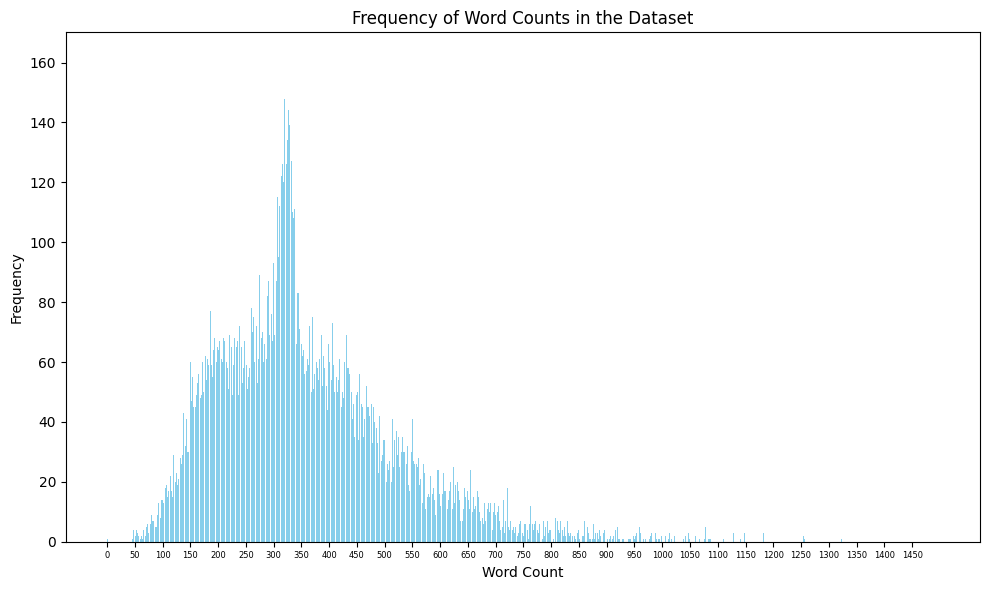

In [ ]:
# Create a bar chart using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(word_counts, frequencies, color='skyblue')

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Frequency of Word Counts in the Dataset')

plt.xticks(range(0, max(word_counts)+1, 50), fontsize = 6)

plt.tight_layout()
plt.show()

In [ ]:
print(len(essays)) #number of essays

29145


In [ ]:
# pick upper and lower limits for the word counts of essays in the dataset on inspection of the chart
max_length = 500
min_length = 200

above_lim = len(essays[essays['numWords'] > max_length])
below_lim = len(essays[essays['numWords'] < min_length])

print("Number of essays with word count greater than", max_length, ":", above_lim)
print("Number of essays with word count lower than", min_length, ":", below_lim)

Number of essays with word count greater than 500 : 4806
Number of essays with word count lower than 200 : 4367


In [ ]:
# Filter out essays with word counts outside upper and lower limits from before
filtered_essays = essays[(essays['numWords'] >= min_length) & (essays['numWords'] <= max_length)]
print(len(filtered_essays))
print(filtered_essays[['generated']].sum())

19972
generated    8274
dtype: int64


# Converting Essays to respective GloVe Indices
All essays need to be converted to their GloVe indices so that their embeddings can be found during the forward pass. To simplify this task, all punctuation was removed from the essays as they do not have a GloVe embedding and punctuation likely will not impact our results significantly. All essays were padded to become the same length.

In [ ]:
import string
# Function to remove punctuation from a string
def remove_punctuation(text):
    return ''.join(char for char in text if char not in string.punctuation)

In [ ]:
# cleaning provided all essays & truths in "filtered_essays" and max length of our set of essays in "max_length"

# Step 1: extract the essays and the ground truths from the file (stored in "filtered_essays" after cleaning)
essays_with_punctuation = filtered_essays['text'].tolist()  # Essays column
essays = [remove_punctuation(essay) for essay in essays_with_punctuation]
ground_truths = filtered_essays['generated'].tolist()  # Ground truths column

# Step 2: Load Pre-trained GloVe Embeddings
glove_embeddings = vocab.GloVe(name='6B', dim=100)

# Step 3: Build a dictionary to hold the vocabulary and each word's GloVe Index
word_to_glove_index = {}
for essay in essays:
    words = essay.lower().split()  # Tokenize and convert to lowercase
    for word in words:
        # Check if the word is not punctuation, is in GloVe embeddings, and not already in the vocabulary
        if word in glove_embeddings.stoi and word not in word_to_glove_index:
            word_to_glove_index[word] = glove_embeddings.stoi[word]

# Step 4: Convert essays to sequences of corresponding GloVe indices
indexed_essays = []
for essay in essays:
    words = essay.lower().split()  # Tokenize and convert to lowercase
    essay_as_indices = [word_to_glove_index.get(word, -1) for word in words]  # Get GloVe index for each word
    indexed_essays.append(essay_as_indices)

# Step 5: Pad sequences to ensure they have the same length, max length stored in max_length from cleaning
padded_essays = [essay_as_indices + [0] * (max_length - len(essay_as_indices)) for essay_as_indices in indexed_essays]  # Padding with zeros (assuming index 0 is for padding)

# Step 6: Convert to PyTorch tensor
essays_tensor = torch.tensor(padded_essays, dtype=torch.long)
labels_tensor = torch.tensor(ground_truths, dtype=torch.long)
print(essays_tensor.shape)

# Step 7: combined the processed essays with the ground truths
dataset = torch.utils.data.TensorDataset(essays_tensor, labels_tensor)

# Step 8: split the data into the different sets
num_essays = essays_tensor.size(0) # Total number of essays

# Calculate the number of essays for each set based on percentages: 70%, 15%, 15%
train_size = int(num_essays * 0.7)
val_size = int(num_essays * 0.15)
test_size = num_essays - train_size - val_size  # Ensure balanced splitting

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Define batch size
batch_size = 64

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

vocab_size = glove_embeddings.vectors.size(0)



torch.Size([19972, 500])


# Testing the Processing
To test if the essays were processed correctly, we printed an essay from the data set (at this point, punctuation has been removed but haven't turned all upper case to lower case yet) and then took the index version of the same essay and converted it back from indices to words using GloVe mapping. The converted version should match the essay, and it does which signifies processing was done correctly.

In [ ]:
# should test this by printing out an essay and then printing out the processed index version
# and then using the GloVe library, get the word matching that index to check if output = input

# Retrieve the first essay (in words) from the essays list
test_essay = essays[0]

# Retrieve the first essay converted into indices and then back into words using the GloVe embeddings
test_indexed_essay = indexed_essays[0]
print("Essay in Index form:", test_indexed_essay)

# convert the keys of glove_embeddings to a list so we can index through it
# Access individual words and their embeddings
glove_words = glove_embeddings.itos  # List of words
glove_word_vectors = glove_embeddings.vectors  # Tensor of word vectors
glove_words_list = list(glove_words)

# Convert the indices back to words using GloVe embeddings
test_index_essay_to_words = []
for index in test_indexed_essay:
    if index == -1: continue   # skip unknown words
    elif index == 0: break  # once we reach the padding, no more words to convert

    word = glove_words_list[index]  # Get the word corresponding to the index
    test_index_essay_to_words.append(word)


# Print and compare the original and converted essays
print("Original Essay (in words):", test_essay)
print("Converted Essay (in words):", test_index_essay_to_words)


Essay in Index form: [569, 415, 1183, 325006, 1183, 7, 2986, 5195, 14669, 6, 3226, 2227, 1555, 1762, 4, 8216, 0, 179, 53, 682, 17949, 12574, 17, 162, 13872, 158, 1183, 21673, 7, 581, 111, 672, 11571, 32, 900, 5416, 5595, 2215, 4505, 25, 2227, 14054, 433, 927, 2488, 13930, 3, 2268, 989, 7410, 5554, 756, 6, 37, 9559, 53, 43, 6167, 0, 917, 4404, 3, 325006, 1183, 144, 44, 1913, 3000, 1156, 4800, 0, 1159, 3, 325006, 1183, 9614, 25, 7, 988, 5418, 3, 0, 2563, 3996, 3, -1, 2227, 1555, 13382, 325, 4570, 0, 18271, 1506, 3, 214, 6, 5700, 14844, -1, 1736, 33, 3511, 2227, 11797, 4, 1762, 8317, 325006, 1183, 901, 201, 8040, 1697, 14608, 21, 3859, 0, 223, 3, 1634, 13, 0, 586, 325006, 1183, 3542, 6748, 325, 4570, 6704, 851, 4250, 37, 1065, 1811, 1697, 14608, 3663, 2076, 1948, 511, 37166, 12326, 16160, 2227, 11066, 198, 360, 3169, 1277, 13, 0, 586, 1702, 3169, 5367, 7, 7861, 1557, 17190, 15300, 6551, 0, 3485, 6, 325, 4570, 604, 6, 2338, 8306, 16554, 360, 115, 19032, 4810, 863, 17572, 325006, 1183, 3306

# Model Definition

In [ ]:
# Model code
class AI_Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(AI_Classifier, self).__init__()
        self.name = "AI_Classifier"
        self.emb = nn.Embedding.from_pretrained(glove_embeddings.vectors)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size) # Output size should = 2

    def forward(self, x):
        # Look up embeddings
        # Mask out-of-range indices
        mask = (x >= 0) & (x < self.emb.num_embeddings)
        x = torch.where(mask, x, torch.zeros_like(x))
        x = self.emb(x)
        # Set the initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # Forward propagate
        out, _ = self.rnn(x, h0) # Expects input 3D tensor of (batch_size, seq_length, input_size)
        # Fully connected layer
        out = self.fc(out[:, -1, :])
        # Apply softmax to get 0/1
        return F.log_softmax(out, dim=1)


In [ ]:
# Count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

lstm_model = AI_Classifier(100, 64, 2, 2)
total_params = count_parameters(lstm_model)
print("Total number of parameters:", total_params)

Total number of parameters: 56962


# Model Training Code

In [ ]:
###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

###############################################################################
# Evaluate function
def get_accuracy(model, data):
  numCorrect = 0
  numTotal = 0
  for batch in data:
    inputs, labels = batch
    output = model(inputs)
    predicted = output.argmax(dim=1)
    numCorrect += (predicted == labels).sum().item()
    numTotal += labels.size(0)

  accuracy = numCorrect/numTotal
  return accuracy

def get_type_one_error(model, data):
  numClassifiedWronglyAsAI = 0
  totalNumClassifiedWrongly = 0
  for batch in data:
    inputs, labels = batch
    output = model(inputs)
    predicted = output.argmax(dim=1)
    numCorrect = (predicted == labels).sum().item()
    totalNumClassifiedWrongly += (labels.size(0) - numCorrect)
    numClassifiedWronglyAsAI += ((predicted == 1) & (labels == 0)).sum().item()

  return numClassifiedWronglyAsAI/totalNumClassifiedWrongly

def  get_loss(model, data, criterion):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_batches = 0

    with torch.no_grad():  # Disable gradient computation
        for batch in data:
            inputs, labels = batch
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            total_loss += loss.item()
            total_batches += 1

    average_loss = total_loss / total_batches
    return average_loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

################################################################################
# NOTE: Ground truth labels are 0/1's with AI generated = 1
# Training code!
def train(model, train, val, n_epochs=15, lr=1e-2, batch_size=25):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  # Set up some numpy arrays to store the training/test loss/erruracy
  train_err = np.zeros(n_epochs)
  train_loss = np.zeros(n_epochs)
  val_err = np.zeros(n_epochs)
  val_loss = np.zeros(n_epochs)
  for epoch in range(n_epochs):
    total_train_err = 0.0
    total_train_loss = 0.0
    total_epoch = 0
    for i, data in enumerate(train, 0):
      essays, labels = data
      #print(essays.shape)
      optimizer.zero_grad()
      pred = model(essays)
      loss = criterion(pred, labels.long())
      loss.backward()
      optimizer.step()
      # Calculate the statistics
      total_train_loss += loss.item()
    train_err[epoch] = 1 - get_accuracy(model, train)
    train_loss[epoch] = float(total_train_loss) / (i+1)
    val_err[epoch] = 1- get_accuracy(model, val)
    val_loss[epoch] = get_loss(model, val, criterion)
    print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
    # Save the current model (checkpoint) to a file
    model_path = get_model_name(model.name, batch_size, lr, epoch)
    torch.save(model.state_dict(), model_path)
  print('Finished Training')
  # Write the train/test loss/err into CSV file for plotting later
  epochs = np.arange(1, n_epochs + 1)
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

  # Plot
  model_path = get_model_name(model.name, batch_size, lr, n_epochs - 1)
  plot_training_curve(model_path)

# Train the model!

Epoch 1: Train err: 0.06944908180300502, Train loss: 0.5601055152872776 |Validation err: 0.07512520868113526, Validation loss: 0.2055425152499625
Epoch 2: Train err: 0.033055091819699456, Train loss: 0.14316879993582027 |Validation err: 0.04340567612687818, Validation loss: 0.13048352554757545
Epoch 3: Train err: 0.019365609348914847, Train loss: 0.086107943603333 |Validation err: 0.03138564273789646, Validation loss: 0.09901100714155968
Epoch 4: Train err: 0.010684474123539234, Train loss: 0.057502219904253776 |Validation err: 0.022704507512520844, Validation loss: 0.07919778821474695
Epoch 5: Train err: 0.00968280467445748, Train loss: 0.0505599630104893 |Validation err: 0.031051752921535947, Validation loss: 0.1122468662586935
Epoch 6: Train err: 0.03606010016694494, Train loss: 0.03169343798629385 |Validation err: 0.05943238731218703, Validation loss: 0.23982996414316463
Epoch 7: Train err: 0.0013355592654423765, Train loss: 0.03536578537549506 |Validation err: 0.024707846410684464

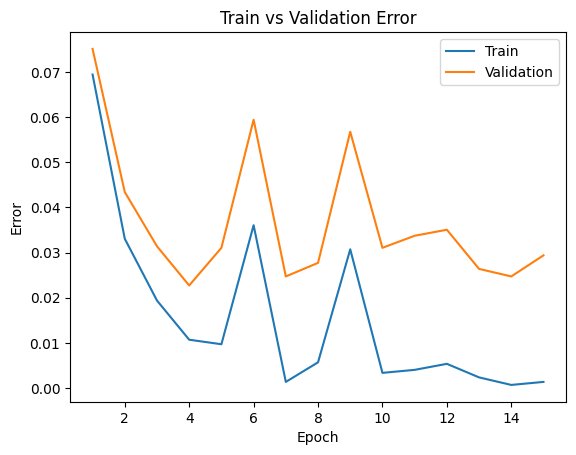

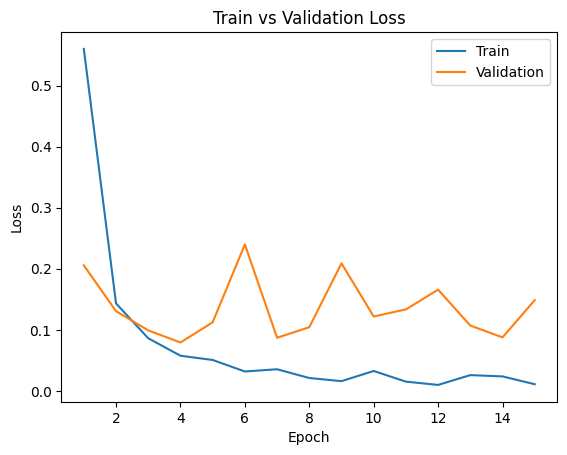

In [ ]:
# Define the model
input_size = 100  # size of word embeddings
hidden_size = 64
num_layers = 2
output_size = 2  # binary classification (human or AI generated)
seq_length = 20  # length of input sequence

# Initialize the classifier
Main_Model = AI_Classifier(input_size, hidden_size, num_layers, output_size)

# Train the model using the updated training code
train(Main_Model, train_loader, val_loader, n_epochs=15, lr=1e-2, batch_size=25)  #updated the model to these parameters

In [ ]:
# Save model dictionary
torch.save(Main_Model.state_dict(), 'model.pth')
from google.colab import files
files.download('model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Qualitative Testing
Going to print out 5 essays in each category to try to find qualitative reasons for the classification (true positives, true negatives, false positives, false negatives)

In [ ]:
def split_data_by_class(data):
    class_data = {0: [], 1: []}  # Assuming binary classification

    for batch in data:
        essays, labels = batch
        for i, label in enumerate(labels):
            class_data[label.item()].append((essays[i], label))

    return class_data

def get_accuracy_by_class(model, class_data):
    class_accuracy = {}

    for label, class_subset in class_data.items():
        num_correct = 0
        num_total = len(class_subset)
        for essay, label in class_subset:
            output = model(essay.unsqueeze(0))  # Assuming model takes single input
            predicted = output.argmax(dim=1)
            num_correct += (predicted == label).item()

        class_accuracy[label] = (num_correct / num_total) * 100 if num_total > 0 else 0

    return class_accuracy

class_data = split_data_by_class(val_loader)
class_accuracy = get_accuracy_by_class(Main_Model, class_data)

flag = False
for label, accuracy in class_accuracy.items():
    # print("Accuracy for class", label, ":", accuracy)
    if flag: print("False Positive rate (%):", 100 - accuracy)
    else: print("False Negative rate (%):", 100 - accuracy)
    flag = not flag


False Negative rate (%): 0.6737787759685574
False Positive rate (%): 6.260296540362447


In [ ]:
for label, accuracy in class_accuracy.items():
    # print("Accuracy for class", label, ":", accuracy)
    if flag: print("True Positive rate (%):", accuracy)
    else: print("True Negative rate (%):", accuracy)
    flag = not flag


True Negative rate (%): 99.32622122403144
True Positive rate (%): 93.73970345963755


In [ ]:
def evaluate_model(model, dataloader, amount):
    true_positives = []
    true_negatives = []
    false_positives = []
    false_negatives = []

    true_positives_count = 0
    true_negatives_count = 0
    false_positives_count = 0
    false_negatives_count = 0

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for essays, labels in dataloader:
            outputs = model(essays)
            predictions = torch.argmax(outputs, dim=1)

            for i in range(len(predictions)):
                if predictions[i] == 1 and labels[i] == 1 and true_positives_count < amount:  # True positives
                    true_positives.append((essays[i], predictions[i].item(), labels[i].item()))
                    true_positives_count += 1
                elif predictions[i] == 0 and labels[i] == 0 and true_negatives_count < amount:  # True negatives
                    true_negatives.append((essays[i], predictions[i].item(), labels[i].item()))
                    true_negatives_count += 1
                elif predictions[i] == 1 and labels[i] == 0 and false_positives_count < amount:  # False positives
                    false_positives.append((essays[i], predictions[i].item(), labels[i].item()))
                    false_positives_count += 1
                elif predictions[i] == 0 and labels[i] == 1 and false_negatives_count < amount:  # False negatives
                    false_negatives.append((essays[i], predictions[i].item(), labels[i].item()))
                    false_negatives_count += 1

                # Break the loop if we have collected 5 samples for each category
                if true_positives_count == amount and true_negatives_count == amount and false_positives_count == amount and false_negatives_count == amount:
                    break

            # Break the outer loop if we have collected 5 samples for each category
            if true_positives_count == amount and true_negatives_count == amount and false_positives_count == amount and false_negatives_count == amount:
                break

    return true_positives, true_negatives, false_positives, false_negatives


# Assuming you have defined your DataLoader for validation set as val_loader
true_positives, true_negatives, false_positives, false_negatives = evaluate_model(Main_Model, val_loader, 3)

# Function to print sample essays for each category
def print_sample_essays(category, samples):
    print(f"{category} ({len(samples)} samples):")
    for i, essay_tuple in enumerate(samples, 1):
        essay, prediction, label = essay_tuple
        print(f"Sample {i}:")
        print("Predicted Label:", prediction)
        print("True Label:", label)
        print("Essay:")
        # Convert indices back to words using GloVe embeddings
        essay_words = [glove_embeddings.itos[index] for index in essay if index != 0]  # Skip padding tokens
        print(" ".join(essay_words))  # Print the essay as a single string
        print("\n")

# Now you can print out sample essays for each category
print_sample_essays("True Positives", true_positives)
print_sample_essays("True Negatives", true_negatives)
print_sample_essays("False Positives", false_positives)
print_sample_essays("False Negatives", false_negatives)


True Positives (3 samples):
Sample 1:
Predicted Label: 1
True Label: 1
Essay:
success in any field be it academic professional is a result of many factors adaptability change are two of most essential skills that help an individual survive thrive in any new environment it is a new school a new job a new country ability to adjust to new surroundings situations is critical once an individual has adapted to their new environment ability to drive change can lead to greater success therefore i agree that success involves an ability to survive in a new environment and eventually to change it survival in a new environment requires a willingness to learn adapt to new cultures work environments people in academic settings students may change schools move to new countries their studies which can be overwhelming however those who succeed are often ones who can adapt to their new surroundings learn new languages embrace new cultures example a student who moves from a small town to a big city colle

### Testing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

modelPath = '/content/gdrive/My Drive/APS360/Project/model.pth'

# Define the model
input_size = 100  # size of word embeddings
hidden_size = 64
num_layers = 2
output_size = 2  # binary classification (human or AI generated)
seq_length = 20  # length of input sequence

# Initialize the LSTM classifier
Test_Model = AI_Classifier(input_size, hidden_size, num_layers, output_size)

# Load the saved state dictionary
state_dict = torch.load(modelPath)

# Apply the state dictionary to the model
Test_Model.load_state_dict(state_dict)

# Import NEW SAMPLES/TEST DATA
test_accuracy = get_accuracy(Test_Model, test_loader)
print("Test Accuracy = ", test_accuracy)

type_one_error = get_type_one_error(Test_Model, test_loader)
print("Percent of error due to human essays being classified as AI: ", type_one_error)